In [1]:
#Let’s start by importing both pandas and our data in Python and taking a look at the first five rows.
import pandas as pd
gl = pd.read_csv('game_logs.csv')
gl.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13,14,15,19,20,81,83,85,87,93,94,95,96,97,98,99,100,105,106,108,109,111,112,114,115,117,118,120,121,123,124,126,127,129,130,132,133,135,136,138,139,141,142,144,145,147,148,150,151,153,154,156,157,160) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,18710504,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,18710505,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,18710506,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,18710508,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,18710509,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


In [2]:
#By default, pandas approximates the memory usage of the dataframe to save time. 
#Because we’re interested in accuracy, we’ll set the memory_usage parameter to 'deep' to get an accurate number.
gl.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171907 entries, 0 to 171906
Columns: 161 entries, date to acquisition_info
dtypes: float64(77), int64(6), object(78)
memory usage: 861.6 MB


In [3]:
# For blocks representing numeric values like integers and floats, pandas combines the columns and 
#stores them as a NumPy ndarray. The NumPy ndarray is built around a C array, and the values are 
#stored in a contiguous block of memory. Due to this storage scheme, accessing a slice of values is incredibly fast.
#In Pandas, similar data types are stored together to improve data read efficiency.
#Because each data type is stored separately, we’re going to examine the memory usage by data type. 
#Let’s start by looking at the average memory usage for data type.
for dtype in ['float','int','object']:
    selected_dtype = gl.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 1.29 MB
Average memory usage for int columns: 1.12 MB
Average memory usage for object columns: 9.53 MB


In [4]:
#An int8 value uses 1 byte (or 8 bits) to store a value, and can represent 256 values (2^8) in binary. 
#This means that we can use this subtype to represent values ranging from -128 to 127 (including 0).
#We can use the numpy.iinfo class to verify the minimum and maximum values for each integer subtype. 
#Let’s look at an example:
import numpy as np
int_types = ["uint8", "int8", "int16"]
for it in int_types:
    print(np.iinfo(it))

Machine parameters for uint8
---------------------------------------------------------------
min = 0
max = 255
---------------------------------------------------------------

Machine parameters for int8
---------------------------------------------------------------
min = -128
max = 127
---------------------------------------------------------------

Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------



In [5]:
# We can use the function pd.to_numeric() to downcast our numeric types. 
# We’ll use DataFrame.select_dtypes to select only the integer columns, then we’ll optimize the types 
# and compare the memory usage.
# We're going to be calculating memory usage a lot,
# so we'll create a function to save us some time!
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)
gl_int = gl.select_dtypes(include=['int'])
converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
print(mem_usage(gl_int))
print(mem_usage(converted_int))
compare_ints = pd.concat([gl_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

7.87 MB
1.48 MB


,before,after
uint8,NaN,5.0
uint32,NaN,1.0
int64,6.0,NaN


In [6]:
#We can see a drop from 7.9 to 1.5 megabytes in memory usage, which is a more than 80% reduction. 
#The overall impact on our original dataframe isn’t massive though, because there are so few integer columns.

gl_float = gl.select_dtypes(include=['float'])
converted_float = gl_float.apply(pd.to_numeric,downcast='float')
print(mem_usage(gl_float))
print(mem_usage(converted_float))
compare_floats = pd.concat([gl_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

100.99 MB
50.49 MB


,before,after
float32,NaN,77.0
float64,77.0,NaN


In [7]:
#We can see that all our float columns were converted from float64 to float32, 
#giving us a 50% reduction in memory usage.
#Let’s create a copy of our original dataframe, assign these optimized numeric columns 
#in place of the originals, and see what our overall memory usage is now.

optimized_gl = gl.copy()
optimized_gl[converted_int.columns] = converted_int
optimized_gl[converted_float.columns] = converted_float
print(mem_usage(gl))
print(mem_usage(optimized_gl))

861.57 MB
804.69 MB


In [8]:
#While each pointer takes up 1 byte of memory, each actual string value uses the same amount of memory that 
#string would use if stored individually in Python. Let’s use sys.getsizeof() to prove that out, 
#first by looking at individual strings, and then items in a pandas series.
from sys import getsizeof
s1 = 'working out'
s2 = 'memory usage for'
s3 = 'strings in python is fun!'
s4 = 'strings in python is fun!'
for s in [s1, s2, s3, s4]:
    print(getsizeof(s))

60
65
74
74


In [9]:

obj_series = pd.Series(['working out',
    'memory usage for',
    'strings in python is fun!',
    'strings in python is fun!'])
obj_series.apply(getsizeof)

0    60
1    65
2    74
3    74
dtype: int64

In [10]:
gl_obj = gl.select_dtypes(include=['object']).copy()
gl_obj.describe()

,day_of_week,v_name,v_league,h_name,h_league,day_night,completion,forefeit,protest,park_id,...,h_player_6_id,h_player_6_name,h_player_7_id,h_player_7_name,h_player_8_id,h_player_8_name,h_player_9_id,h_player_9_name,additional_info,acquisition_info
count,171907,171907,171907,171907,171907,140150,116,145,180,171907,...,140838,140838,140838,140838,140838,140838,140838,140838,1456,140841
unique,7,148,7,148,7,2,116,3,5,245,...,4774,4720,5253,5197,4760,4710,5193,5142,332,1
top,Sat,CHN,NL,CHN,NL,D,"20041003,,5,5,66",H,V,STL07,...,grimc101,Charlie Grimm,grimc101,Charlie Grimm,lopea102,Al Lopez,spahw101,Warren Spahn,HTBF,Y
freq,28891,8870,88866,9024,88867,82724,1,69,90,7022,...,427,427,491,491,676,676,339,339,1112,140841


In [11]:
dow = gl_obj.day_of_week
print(dow.head())
dow_cat = dow.astype('category')
print(dow_cat.head())

0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: object
0    Thu
1    Fri
2    Sat
3    Mon
4    Tue
Name: day_of_week, dtype: category
Categories (7, object): [Fri, Mon, Sat, Sun, Thu, Tue, Wed]


In [12]:
dow_cat.head().cat.codes

0    4
1    0
2    2
3    1
4    5
dtype: int8

In [13]:
print(mem_usage(dow))
print(mem_usage(dow_cat))

9.84 MB
0.16 MB


In [14]:
# We’ve gone from 9.8MB of memory usage to 0.16MB of memory usage, or a 98% reduction! 
# Note that this particular column probably represents one of our best-case scenarios – a column with 
# ~172,000 items of which there are only 7 unique values.
converted_obj = pd.DataFrame()
for col in gl_obj.columns:
    num_unique_values = len(gl_obj[col].unique())
    num_total_values = len(gl_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = gl_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = gl_obj[col]

In [15]:
print(mem_usage(gl_obj))
print(mem_usage(converted_obj))
compare_obj = pd.concat([gl_obj.dtypes,converted_obj.dtypes],axis=1)
compare_obj.columns = ['before','after']
compare_obj.apply(pd.Series.value_counts)


752.72 MB
51.67 MB


,before,after
object,78.0,NaN
category,NaN,2.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
...,...,...
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0
category,NaN,1.0


In [16]:
optimized_gl[converted_obj.columns] = converted_obj
mem_usage(optimized_gl)

'103.64 MB'

In [17]:
date = optimized_gl.date
print(mem_usage(date))
date.head()

0.66 MB


0    18710504
1    18710505
2    18710506
3    18710508
4    18710509
Name: date, dtype: uint32

In [18]:
'''
optimized_gl['date'] = pd.to_datetime(date,format='%Y%m%d')
print(mem_usage(optimized_gl))
optimized_gl.date.head()
'''

104.29 MB


0   1871-05-04
1   1871-05-05
2   1871-05-06
3   1871-05-08
4   1871-05-09
Name: date, dtype: datetime64[ns]

In [20]:
pip install pprintpp

Note: you may need to restart the kernel to use updated packages.


In [22]:
dtypes = optimized_gl.drop('date',axis=1).dtypes
dtypes_col = dtypes.index
dtypes_type = [i.name for i in dtypes.values]
column_types = dict(zip(dtypes_col, dtypes_type))
# rather than print all 161 items, we'll
# sample 10 key/value pairs from the dict
# and print it nicely using prettyprint
preview = first2pairs = {key:value for key,value in list(column_types.items())[:10]}
import pprintpp
pp = pprintpp.PrettyPrinter(indent=4)
pp.pprint(preview)

{
    'day_of_week': 'category',
    'h_game_number': 'uint8',
    'h_league': 'category',
    'h_name': 'category',
    'h_score': 'uint8',
    'number_of_game': 'uint8',
    'v_game_number': 'uint8',
    'v_league': 'category',
    'v_name': 'category',
    'v_score': 'uint8',
}


In [23]:
read_and_optimized = pd.read_csv('game_logs.csv',dtype=column_types,parse_dates=['date'],infer_datetime_format=True)
print(mem_usage(read_and_optimized))
read_and_optimized.head()

104.28 MB


,date,number_of_game,day_of_week,v_name,v_league,v_game_number,h_name,h_league,h_game_number,v_score,...,h_player_7_name,h_player_7_def_pos,h_player_8_id,h_player_8_name,h_player_8_def_pos,h_player_9_id,h_player_9_name,h_player_9_def_pos,additional_info,acquisition_info
0,1871-05-04,0,Thu,CL1,na,1,FW1,na,1,0,...,Ed Mincher,7.0,mcdej101,James McDermott,8.0,kellb105,Bill Kelly,9.0,NaN,Y
1,1871-05-05,0,Fri,BS1,na,1,WS3,na,1,20,...,Asa Brainard,1.0,burrh101,Henry Burroughs,9.0,berth101,Henry Berthrong,8.0,HTBF,Y
2,1871-05-06,0,Sat,CL1,na,2,RC1,na,1,12,...,Pony Sager,6.0,birdg101,George Bird,7.0,stirg101,Gat Stires,9.0,NaN,Y
3,1871-05-08,0,Mon,CL1,na,3,CH1,na,1,12,...,Ed Duffy,6.0,pinke101,Ed Pinkham,5.0,zettg101,George Zettlein,1.0,NaN,Y
4,1871-05-09,0,Tue,BS1,na,2,TRO,na,1,9,...,Steve Bellan,5.0,pikel101,Lip Pike,3.0,cravb101,Bill Craver,6.0,HTBF,Y


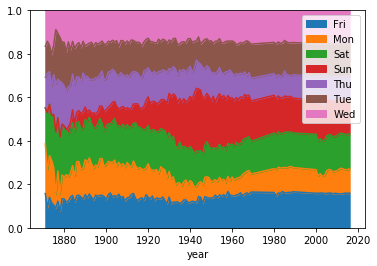

In [25]:
##Now that we’ve optimized our data, we can perform some analysis. 
#Let’s start by looking at the distribution of game days.
import matplotlib.pyplot as plt
optimized_gl['year'] = optimized_gl.date.dt.year
games_per_day = optimized_gl.pivot_table(index='year',columns='day_of_week',values='date',aggfunc=len)
games_per_day = games_per_day.divide(games_per_day.sum(axis=1),axis=0)
ax = games_per_day.plot(kind='area',stacked='true')
ax.legend(loc='upper right')
ax.set_ylim(0,1)
plt.show()


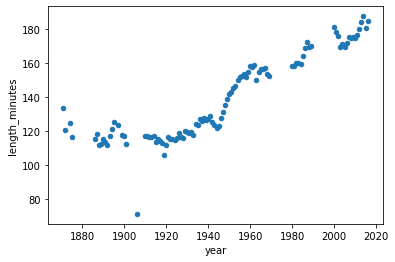

In [26]:
game_lengths = optimized_gl.pivot_table(index='year', values='length_minutes')
game_lengths.reset_index().plot.scatter('year','length_minutes')
plt.show()